In [0]:
# colab version

In [0]:
DEBUG = False

In [0]:
import numpy as np
import pandas as pd
import os, random, glob, cv2, gc
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from termcolor import colored

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import FloatTensor

from albumentations import Compose, Normalize, HorizontalFlip, VerticalFlip, Transpose
from zipfile import ZipFile
from functools import partial
import scipy as sp
import time

In [135]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [0]:
class config:
    IMG_SIZE = 512
    BS = 4
    SZ = 256
    N = 36
    LEVEL = 1
    LOG = 'train.txt'
    SEED = 2020

In [0]:
# seed
def seed_everything(seed=2020):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(config.SEED)

In [0]:
Image.MAX_IMAGE_PIXELS = 933120000

In [138]:
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [8]:
!kaggle datasets download lopuhin/panda-2020-level-1-2

100% 9.10G/9.10G [03:33<00:00, 33.8MB/s]
100% 9.10G/9.10G [03:33<00:00, 45.8MB/s]


In [17]:
# test zip file
myzip = ZipFile('panda-2020-level-1-2.zip')
files = myzip.infolist()
f = myzip.open(files[1])
img = Image.open(f)
print(img.size, img.mode, len(img.getdata()))

(1368, 5376) RGB 7354368


# Data

In [139]:
df = pd.read_csv("train.csv").set_index('image_id')
df.head()

,data_provider,isup_grade,gleason_score,split
image_id,,,,
2362d93816e6dff7db5f3de85b660777,radboud,1,3+3,5.0
d527d0d353eef920f47505af9fe37956,radboud,2,3+4,6.0
c874de63fb72b5c081bbea4a5a7aae65,radboud,0,negative,2.0
dbf5972f6e8559cf175c232310070b6e,karolinska,1,3+3,0.0
0e1f3c283a5756b1372fc67e5230dd35,radboud,1,3+3,2.0


In [140]:
# shuffle
df = shuffle(df)

# split
train_df, val_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(val_df, test_size=0.2)

train_df = train_df[:100].reset_index() if DEBUG else train_df.reset_index()
val_df = val_df[:100].reset_index() if DEBUG else val_df.reset_index()
test_df = test_df.reset_index()

print(len(train_df), len(val_df), len(test_df))

8492 1699 425


In [141]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score,split
0,a53a67696219b002aa38d0f425de817d,karolinska,0,0+0,4.0
1,9cacb539b16561b6987029301b5f4bff,radboud,1,3+3,3.0
2,69bf739361bfca3db482e3ce7249fa55,karolinska,0,0+0,0.0
3,aa176f6d6e5674ccf6e19ef3aeb3e243,radboud,5,4+5,4.0
4,6959e859a5eeb9cd1a04266829bb4b47,karolinska,5,4+5,1.0


# Augmentation

In [0]:
train_transforms = Compose([HorizontalFlip(p=0.5), 
                            Transpose(p=0.5),
                            VerticalFlip(p=0.5)])
val_transforms = Compose([])

# Dataset

In [0]:
def get_tiles(img, level=1, SZ=256, N=36, mode=0):

    h, w, c = img.shape
    pad_h = (SZ - h % SZ) % SZ + ((SZ * mode) // 2)
    pad_w = (SZ - w % SZ) % SZ + ((SZ * mode) // 2)

    img2 = np.pad(img, [[pad_h // 2, pad_h - pad_h // 2], 
                        [pad_w // 2, pad_w - pad_w//2], 
                        [0,0]], constant_values=255)
    img3 = img2.reshape(
        img2.shape[0] // SZ,
        SZ,
        img2.shape[1] // SZ,
        SZ,
        3
    )
    
    img3 = img3.transpose(0, 2, 1, 3, 4).reshape(-1, SZ, SZ, 3) # (783, 256, 256, 3)

    # supplement
    if len(img3) < N:
        img3 = np.pad(img3, [ [0, N-len(img3)], [0,0],[0,0],[0,0]], constant_values=255)
        
    idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:N]
    img3 = img3[idxs]
    
    return img3

In [0]:
class MyDataset(Dataset):
    def __init__(self, df, split='train', shuffle=False, shuffle_tiles=False):
        super().__init__()
        if shuffle:
            df = shuffle(df)
        self.df = df.reset_index(drop=True)

        self.split = split
        self.shuffle_tiles = shuffle_tiles
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name = self.df.image_id[idx]
        f = myzip.open(f'train_images/train_images/{name}_1.jpeg')
        img = Image.open(f)
        img = np.array(img)

        # get tiles
        tiles = get_tiles(img, config.LEVEL, config.SZ, config.N)
        
        # apply transform to each img
        imgs = []
        for t in tiles:
            if self.split == 'train':
                t_aug = train_transforms(**{'image': t})['image']
            elif self.split == 'val':
                t_aug = val_transforms(**{'image': t})['image']
                
            imgs.append(t_aug) # already tensor
        
        
        # shuffle tiles
        if self.shuffle_tiles:
            imgs = shuffle(imgs)
            
        
        # concat
        n = int(np.sqrt(config.N))
        images = np.zeros((config.SZ*n, config.SZ*n, 3), dtype=np.int32)
        for i in range(n):
            for j in range(n):
                images[i*config.SZ : (i+1)*config.SZ, j*config.SZ : (j+1)*config.SZ, :] = imgs[i*n+j]
             
            
        
        # normalize
        images = 255 - images # reverse 
        images = images / 255. # [0, 1]
        
        
        
        # resize 
        images = cv2.resize(images, (config.IMG_SIZE, config.IMG_SIZE))
        images = torch.tensor(images).permute(2, 0, 1)
        label = torch.tensor(self.df.isup_grade[idx])
        return images, label

        

torch.Size([3, 512, 512])


Text(0.5, 1.0, 'tensor(0)')

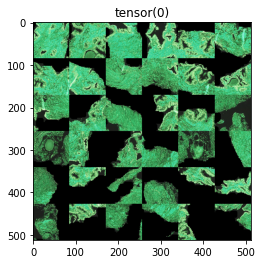

In [145]:
# test dataset
train_ds = MyDataset(train_df, 'train')
x, y = train_ds[2]
print(x.shape)
plt.imshow(x.permute(1, 2, 0).numpy())
plt.title(y)

In [0]:
train_ds = MyDataset(train_df, 'train')
train_dl = DataLoader(train_ds, batch_size=config.BS, shuffle=True) # use 32 means 2 images per batch, don't shuffle to preserve 

val_ds = MyDataset(val_df, 'val')
val_dl = DataLoader(val_ds, batch_size=config.BS, shuffle=True)

test_ds = MyDataset(test_df, 'val')
test_dl = DataLoader(test_ds, batch_size=config.BS, shuffle=True)

Text(0.5, 1.0, 'tensor(4)')

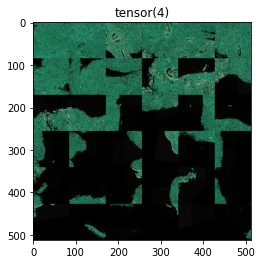

In [147]:
# test dl
x, y = next(iter(train_dl))
plt.imshow(x[0].permute(1, 2, 0).numpy())
plt.title(y[0])

# Model

In [0]:
from collections import OrderedDict
import math


class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']


def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = config.pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = config.pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [0]:
class CustomSEResNeXt(nn.Module):

    def __init__(self, model_name='se_resnext50_32x4d'):
        assert model_name in ('se_resnext50_32x4d')
        super().__init__()
        
        self.model = se_resnext50_32x4d(pretrained=None)
        self.model.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.model.last_linear = nn.Linear(self.model.last_linear.in_features, 1)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [0]:
model = CustomSEResNeXt(model_name='se_resnext50_32x4d')
_ = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.) # traditional lr
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, verbose=1)

In [0]:
# test model
if DEBUG:
    x = torch.randn(2, 3, 512, 512)
    x = x.to(device, dtype=torch.float32)
    y = model(x)
    print(y.shape)

# Training

In [0]:
class OptimizedRounder():
    def __init__(self):
        self.coef_ = [0.5, 1.5, 2.5, 3.5, 4.5]

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            else:
                X_p[i] = 5

        ll = cohen_kappa_score(y, X_p, weights='quadratic')

        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef=[0.5, 1.5, 2.5, 3.5, 4.5]):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            else:
                X_p[i] = 5
        return X_p

    def coefficients(self):
        '''use after self.fit or error throws'''
        return self.coef_['x']

In [0]:
rounder = OptimizedRounder()

In [0]:
def train_on(epoch):
    
    torch.cuda.empty_cache()
    gc.collect()
    
    model.train()
    
    loss_epoch = []
    preds_epoch = []
    y_epoch = []
    bar = tqdm(enumerate(train_dl), total=len(train_dl))
    for i, (x, y) in bar:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        y_preds = model(x) # [batch, 1]
        y_preds = y_preds.view(-1) #[batch,]
        
        # get metrics
        loss = nn.MSELoss()(y_preds, y)

        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # add
        y_np = y.cpu().detach().numpy()
        y_preds_np = rounder.predict(y_preds.cpu().detach().numpy())
        loss_np = loss.cpu().detach().numpy()
        
        # add
        preds_epoch.append(y_preds_np)
        y_epoch.append(y_np)
        loss_epoch.append(loss_np)
    
        
        c = cohen_kappa_score(y_np, y_preds_np, weights='quadratic')
        bar.set_description('loss: %.4f, cohen: %.4f' % (loss_np, c))
        
            
        # clean
        del x, y, y_preds, loss, y_np, y_preds_np, loss_np
        torch.cuda.empty_cache()
        gc.collect()
        
        
    cohen = cohen_kappa_score(np.concatenate(preds_epoch), 
                              np.concatenate(y_epoch), 
                              weights='quadratic')
    
    print('Epoch: %d, Loss: %.4f, Cohen: %.4f' % (epoch, np.mean(loss_epoch), cohen))
    return np.mean(loss_epoch), cohen


In [155]:
torch.cuda.empty_cache()
gc.collect()

863

In [0]:
if DEBUG:
    train_on(1)

In [0]:
def val_on(epoch, dl):

    torch.cuda.empty_cache()
    gc.collect()
    
    model.eval()
    
    loss_epoch = []
    preds_epoch = []
    y_epoch = []
    bar = tqdm(enumerate(dl), total=len(dl))
    with torch.no_grad():
        for i, (x, y) in bar:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
            
            y_preds = model(x).view(-1)

            # get metrics
            loss = nn.MSELoss()(y_preds, y)

            # add
            y_preds_np = y_preds.cpu().detach().numpy()
            y_np = y.cpu().detach().numpy()
            loss_np = loss.cpu().detach().numpy()
            
            loss_epoch.append(loss_np)
            preds_epoch.append(y_preds_np)
            y_epoch.append(y_np)
            
            
            # get cohen
            c = cohen_kappa_score(rounder.predict(y_preds_np), y_np, weights='quadratic')
            bar.set_description('loss: %.4f, cohen: %.4f' % (loss_np, c))

        
            # clean
            del x, y, y_preds, loss, y_np, y_preds_np, loss_np, c
            torch.cuda.empty_cache()
            gc.collect()
            

    # cohen
    preds_epoch = np.concatenate(preds_epoch)
    y_epoch = np.concatenate(y_epoch)
    
    rounder.fit(preds_epoch, y_epoch)
    coef = rounder.coefficients()
    preds_epoch = rounder.predict(preds_epoch, coef)
    cohen = cohen_kappa_score(preds_epoch, y_epoch, weights='quadratic')
    
    print('Epoch: %d, Loss: %.4f, Cohen: %.4f' % (epoch, np.mean(loss_epoch), cohen))

    return np.mean(loss_epoch), cohen, coef
        
            

In [0]:
if DEBUG:
    val_on(1, val_dl)

In [0]:
def train(epochs):
    best_cohen = []
    for e in range(epochs):
        train_loss, train_cohen = train_on(e)
        val_loss, val_cohen, coef = val_on(e, val_dl)
        
        # adjust lr
        scheduler.step(val_loss)

        # write to log
        with open(config.LOG, 'a') as f:
            f.write(time.ctime() + f' Epoch: {e}, Train loss: {(train_loss):.4f}, Train cohen: {(train_cohen):.4f}\n   Val loss: {(val_loss):.4f}, Val cohen:{(val_cohen):.4f}, Coef: {coef} \n\n')
            
        # save best
        best_cohen.append(val_cohen)
        if val_cohen >= max(best_cohen):
            print('save best model')
            torch.save(model.state_dict(), f'seresnetxt-best.pth')
            
    torch.save(model.state_dict(), './final.pth')

In [166]:
torch.cuda.empty_cache()
gc.collect()

0

In [0]:
train(3)


Epoch: 0, Loss: 2.3414, Cohen: 0.3806



Epoch: 0, Loss: 2.1302, Cohen: 0.5995
save best model


In [0]:
from IPython.display import FileLink
FileLink('./seresnetxt.pth')